In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imutils
import random

In [2]:
def CriarDataset(diretorio, classes, imagem_dim=200):
    """
    Funcao para criar o conjunto de dados, separando os dados com seus respectivos rotulos,
    a partir do diretorio e o numero de classes informados
    
    Parameters:
    -----------
    diretorio: string
        Diretorio (path) do objeto de estudo
        
    classes: list
        Contém os rotulos que compoem a classificacao dos dados
        
    imagem_dim: int
        Dimensão das imagens de saída 
        
    Return
    -----------
    X: list
        Conjunto de dados em escala de cinza
    
    y: list
        Rotulos referentes ao conjunto de dados
        
    """
    dataset = []
    X = []
    y = []
    for classe in classes:
        path = os.path.join(diretorio, classe)
        classe_num = classes.index(classe)
        for imagem in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_GRAYSCALE)
            #img_redim = cv2.resize(img_array, (imagem_dim, imagem_dim))
            dataset.append([img_array, classe_num])
    
    random.seed(4)
    random.shuffle(dataset)
    for amostras, label in dataset:
        X.append(amostras)
        y.append(label)
    
    return X, y

In [3]:
diretorio = "D:/Datasets/br35h-brain-tumor" #Alterar para diretorio local
classes = ["yes", "no"]
imagem_dim = 224 #Dimensoes recomendadas para arquitetura estado-da-arte DenseNet169

X, y = CriarDataset(diretorio, classes, imagem_dim)

#X = np.array(X).reshape(-1, imagem_dim, imagem_dim, 1)

y = np.array(y)

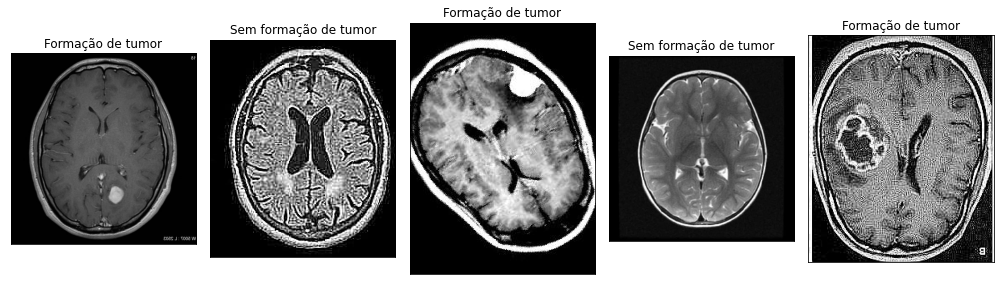

In [25]:
#Visualizacao das imagens que compoem o conjunto de dados
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(14, 14), subplot_kw={'xticks': [], 'yticks': []})

for ax, image, label in zip(axs.flat, X, y):
    ax.imshow(image, cmap="gray")
    if label == 0:
        ax.set_title("Formação de tumor", loc='center', fontsize=12)
    else:
        ax.set_title("Sem formação de tumor", loc='center', fontsize=12)
    

plt.tight_layout()
plt.show()

In [15]:
def RemoverExternoDidatico(imagem):
    """
    Funcao de pre-processamento, responsavel por calcular os pontos extremos da imagem 
    de Ressonancia Magnetica fornecida, eliminando informacoes desnecessarias. Retorna
    o passo a passo do processo, para fins de visualizacao e didaticos.
    
    Parameters:
    -----------
    imagem: numpy.ndarray
        Imagem que sofrerá o pre-processamento
        
    Return
    -----------
    threshold: numpy.ndarray
        Mascara binaria do conteudo relevante da imagem de Ressonancia Magnetica
        
    imagem_contorno: numpy.ndarray
        Imagem com o contorno identificado
    
    imagem_pontos_extremos: numpy.ndarray
        Imagem para visualizacao dos pontos extremos calculados
    
    imagem_cortada: numpy.ndarray
        Imagem com a remocao de espacos dispensaveis
        
    """
    cinza = cv2.GaussianBlur(imagem, (5, 5), 0)
    
    threshold = cv2.threshold(cinza, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_pos = cv2.erode(threshold, None, iterations=2)
    threshold_pos = cv2.dilate(threshold_pos, None, iterations=2)
    
    contorno = cv2.findContours(threshold_pos.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contorno = imutils.grab_contours(contorno)
    pontos_extremos = max(contorno, key=cv2.contourArea)
    
    ponto_esquerdo = tuple(pontos_extremos[pontos_extremos[:, :, 0].argmin()][0])
    ponto_direito = tuple(pontos_extremos[pontos_extremos[:, :, 0].argmax()][0])
    ponto_superior = tuple(pontos_extremos[pontos_extremos[:, :, 1].argmin()][0])
    ponto_inferior = tuple(pontos_extremos[pontos_extremos[:, :, 1].argmax()][0])
    
    imagem_bgr = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)
    
    imagem_contorno = cv2.drawContours(imagem_bgr, [pontos_extremos], -1, (0, 255, 0), 2).copy()
    imagem_pontos_extremos = cv2.circle(imagem_bgr, ponto_esquerdo, 8, (255, 165, 0), -1) #orange
    imagem_pontos_extremos = cv2.circle(imagem_bgr, ponto_direito, 8, (255, 0, 255), -1) #purple
    imagem_pontos_extremos = cv2.circle(imagem_bgr, ponto_superior, 8, (0, 0, 255), -1) #blue
    imagem_pontos_extremos = cv2.circle(imagem_bgr, ponto_inferior, 8, (255, 0, 0), -1) #red
        
    imagem_cortada = imagem[ponto_superior[1]:ponto_inferior[1], ponto_esquerdo[0]:ponto_direito[0]]
    
    return threshold, imagem_contorno, imagem_pontos_extremos, imagem_cortada

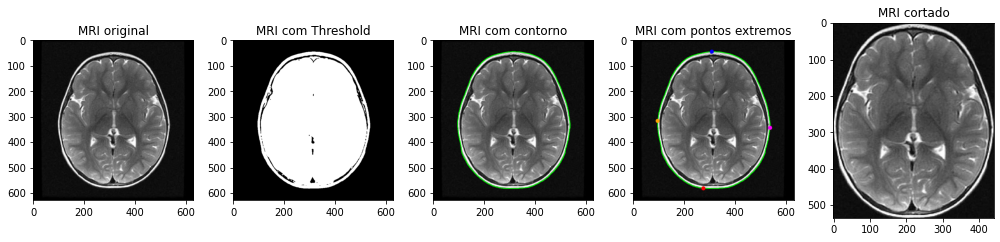

In [18]:
#Visualizacao do processo de remocao do conteudo externo de RM
thresh, contorno, pontos, imagem_cortada = RemoverExternoDidatico(X[3])

fig, ax = plt.subplots(1,5, figsize=(14,14))

ax[0].imshow(X[3], cmap='gray', vmin=0, vmax=255)
ax[1].imshow(thresh, cmap='gray', vmin=0, vmax=255)
ax[2].imshow(contorno, cmap='gray', vmin=0, vmax=255)
ax[3].imshow(pontos, vmin=0, vmax=255)
ax[4].imshow(imagem_cortada, cmap='gray', vmin=0, vmax=255)

titulos=['MRI original',
         'MRI com Threshold',
         'MRI com contorno',
         'MRI com pontos extremos',
         'MRI cortado']

for obj, title in zip(ax.ravel(), titulos):
    obj.set_title(title, loc='center', fontsize=12)

plt.tight_layout()

#plt.savefig('removerExternoDidatica_ex.png')

In [20]:
def RemoverExterno(imagem):
    """
    Funcao de pre-processamento, responsavel por calcular os pontos extremos da imagem 
    de Ressonancia Magnetica fornecida, eliminando informacoes desnecessarias
    
    Parameters:
    -----------
    imagem: numpy.ndarray
        Imagem que sofrerá o pre-processamento
        
    Return
    -----------
    imagem_cortada: numpy.ndarray
        Imagem com a retirada de espacos em preto, tipicos de Ressonancia Magnetica
        
    """
    cinza = cv2.GaussianBlur(imagem, (5, 5), 0)
    
    threshold = cv2.threshold(cinza, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_pos = cv2.erode(threshold, None, iterations=2)
    threshold_pos = cv2.dilate(threshold_pos, None, iterations=2)
    
    contorno = cv2.findContours(threshold_pos.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contorno = imutils.grab_contours(contorno)
    pontos_extremos = max(contorno, key=cv2.contourArea)
    
    ponto_esquerdo = tuple(pontos_extremos[pontos_extremos[:, :, 0].argmin()][0])
    ponto_direito = tuple(pontos_extremos[pontos_extremos[:, :, 0].argmax()][0])
    ponto_superior = tuple(pontos_extremos[pontos_extremos[:, :, 1].argmin()][0])
    ponto_inferior = tuple(pontos_extremos[pontos_extremos[:, :, 1].argmax()][0])

    imagem_cortada = imagem[ponto_superior[1]:ponto_inferior[1], ponto_esquerdo[0]:ponto_direito[0]]
    imagem_cortada = cv2.resize(imagem_cortada, (imagem_dim, imagem_dim))
    
    return imagem_cortada

In [21]:
X_preprocessado = []

for indice in range(len(X)):
    X_preprocessado.append(RemoverExterno(X[indice]))

X_preprocessado = np.array(X_preprocessado).reshape(-1, imagem_dim, imagem_dim, 1)/255

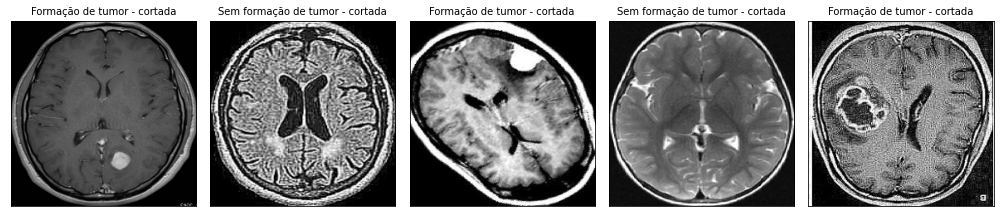

In [26]:
#Visualizacao das imagens que compoem o conjunto de dados apos pre-processamento
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(14, 14), subplot_kw={'xticks': [], 'yticks': []})
    
for ax, image, label in zip(axs.flat, X_preprocessado, y):
    ax.imshow(image, cmap="gray")
    if label == 0:
        ax.set_title("Formação de tumor - cortada", loc='center', fontsize=10)
    else:
        ax.set_title("Sem formação de tumor - cortada", loc='center', fontsize=10)

plt.tight_layout()
plt.show()

#plt.savefig('RMs-preprocessados.png')